In [1]:
import keras
import tensorflow as tf
from keras import layers,Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm_notebook as tqdm
import warnings
import keras.backend as K
import random
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Loading already preprocessed files.
x_test=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/x_test.pkl')
x_train=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/x_train.pkl')
y_test=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/y_test.pkl')
y_train=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/y_train.pkl')
y_cv=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/y_cv.pkl')
x_cv=joblib.load('/content/drive/My Drive/FaceForensics++/pickels_101_frames/x_cv.pkl')

In [0]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

Shape of Train data (7676, 299, 299, 3)
Shape of Cv data (505, 299, 299, 3)
Shape of Test data (2020, 299, 299, 3)


In [0]:
Y_train=to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

### Xception Network

In [0]:
#Greedy Layer-Wise Pretraining Learned from : https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/
# 1. Pre-training the network with train data on initilizing the "imagenet" weights with "include_top=False"
# 2. After training 3 epochs remove the top most layer
# 3. Now add similar top layer and again train and validate


Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )
#print(Xception_pre_trained.summary())

for layer in Xception_initial.layers:
    layer.trainable = True

x = Xception_initial.output
predicted = Dense(2,activation ='softmax')(x)
model_pretrain = Model(input = Xception_initial.input, output = predicted)
model_pretrain.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])
pretraining_Xception =model_pretrain.fit(x_train, Y_train,
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
7676/7676 [==============================] - 192s 25ms/step - loss: 0.0344 - acc: 0.9865
Epoch 2/3
7676/7676 [==============================] - 180s 23ms/step - loss: 0.0040 - acc: 0.9988
Epoch 3/3
7676/7676 [==============================] - 180s 23ms/step - loss: 1.0305e-04 - acc: 1.0000


In [0]:
model_pretrain.layers.pop() # Removing topmost layer

In [0]:
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [0]:

for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune1 = Model(input = model_pretrain.input, output = predicted)
model_finetune1.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])

finetuning1_XceptionNet=model_finetune1.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv)
                      ,callbacks=[tensorboard]
                     )

Train on 7676 samples, validate on 505 samples



Epoch 1/15
7676/7676 [==============================] - 49s 6ms/step - loss: 0.3975 - acc: 0.9999 - val_loss: 0.3686 - val_acc: 0.9604

Epoch 2/15
7676/7676 [==============================] - 45s 6ms/step - loss: 0.3301 - acc: 0.9997 - val_loss: 0.3222 - val_acc: 0.9624
Epoch 3/15
7676/7676 [==============================] - 44s 6ms/step - loss: 0.2777 - acc: 0.9997 - val_loss: 0.2855 - val_acc: 0.9663
Epoch 4/15
7676/7676 [==============================] - 44s 6ms/step - loss: 0.2360 - acc: 0.9996 - val_loss: 0.2559 - val_acc: 0.9663
Epoch 5/15
7676/7676 [==============================] - 43s 6ms/step - loss: 0.2028 - acc: 0.9993 - val_loss: 0.2319 - val_acc: 0.9663
Epoch 6/15
7676/7676 [==============================] - 43s 6ms/step - loss: 0.1745 - acc: 0.9997 - val_loss: 0.2120 - val_acc: 0.9663
Epoch 7/15
7676/7676 [==============================] - 43s 6ms/step - loss: 0.1509 - acc: 0.9999 - val_loss: 0.1956 - val_acc: 0.9663
Epoc

#### Train Accuracy

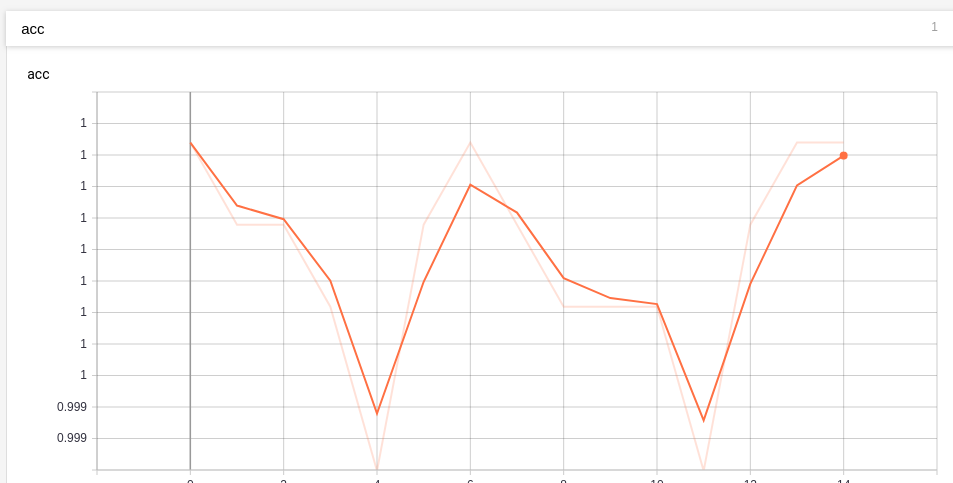

#### Train Loss

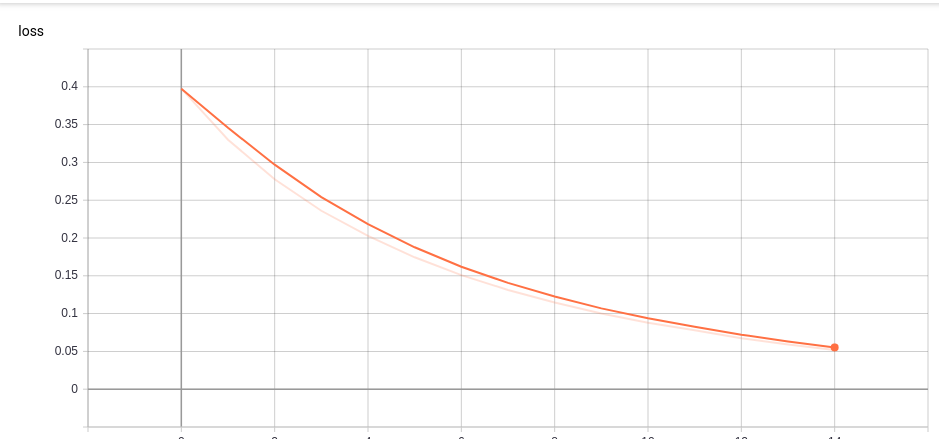

#### Validation Accuracy

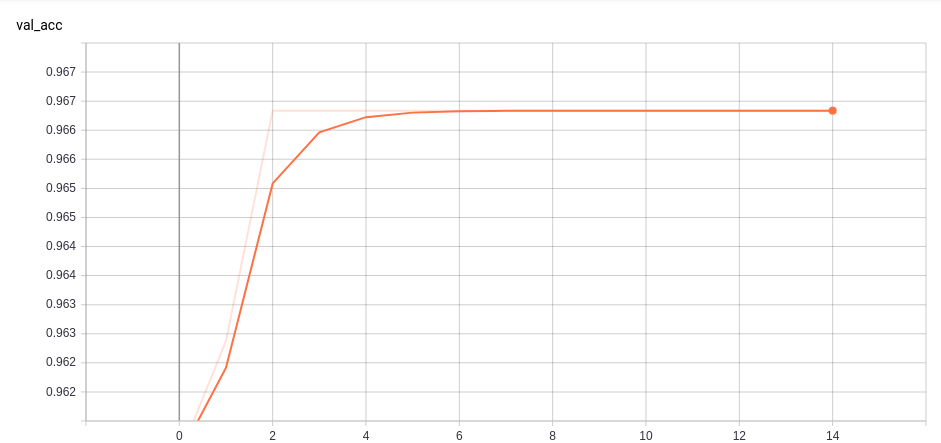

#### Validation Loss

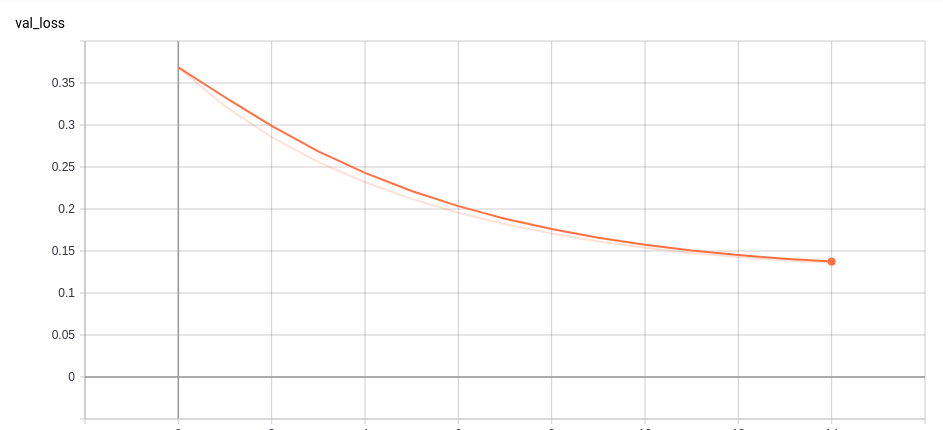

### Weights histogram plot for only TOP dense layer

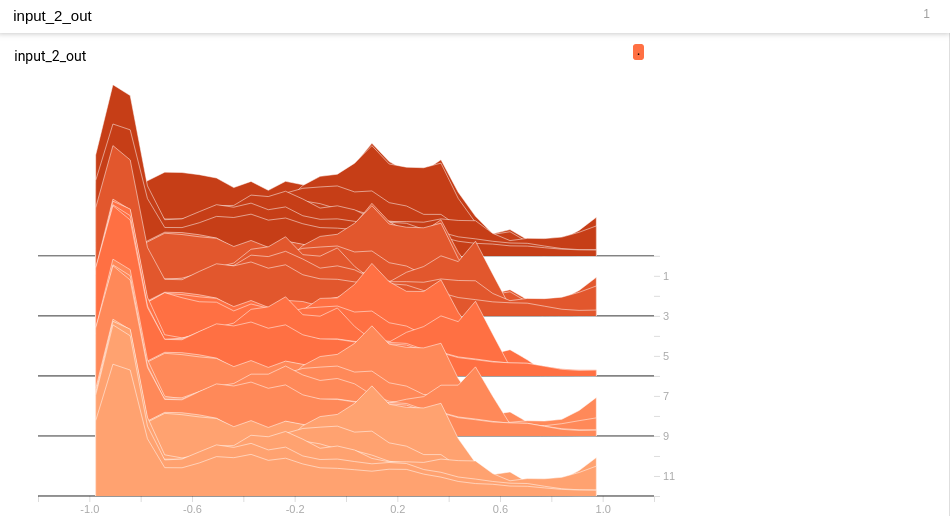

In [0]:
model_finetune1.save("model_finetuned_xception.hdf5")

In [0]:
model_finetune1.evaluate(x_train,Y_train)

7676/7676 [==============================] - 40s 5ms/step


[0.048198134836863575, 1.0]

In [0]:
model_finetune1.evaluate(x_cv,Y_cv)

505/505 [==============================] - 3s 5ms/step


[0.13589911885043182, 0.9663366336633663]

In [0]:
#Unseen data
model_finetune1.evaluate(x_test,Y_test)

2020/2020 [==============================] - 12s 6ms/step


[0.07145962482041651, 0.9910891089108911]